In [1]:
from tqdm import tqdm
import retro
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random, math
from IPython.display import clear_output, display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

import os


#Retro_wrapper

In [2]:
from collections import deque, defaultdict
import cv2
cv2.ocl.setUseOpenCL(False)
#from .atari_wrappers import WarpFrame, ClipRewardEnv, FrameStack, ScaledFloatFrame
#from .wrappers import TimeLimit
import numpy as np
import gym
from gym.wrappers.time_limit import TimeLimit
from matplotlib import pyplot as plt

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=-1)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(shp[:-1] + (shp[-1] * k,)), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = width
        self.height = height
        self.grayscale = grayscale
        if self.grayscale:
            self.observation_space = gym.spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 1), dtype=np.uint8)
        else:
            self.observation_space = gym.spaces.Box(low=0, high=255,
                shape=(self.height, self.width, 3), dtype=np.uint8)

    def observation(self, frame):
        if self.grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        if self.grayscale:
            frame = np.expand_dims(frame, -1)
        return frame

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)



class StochasticFrameSkip(gym.Wrapper):
    def __init__(self, env, n, stickprob):
        gym.Wrapper.__init__(self, env)
        self.n = n
        self.stickprob = stickprob
        self.curac = None
        self.rng = np.random.RandomState()
        self.supports_want_render = hasattr(env, "supports_want_render")

    def reset(self, **kwargs):
        self.curac = None
        return self.env.reset(**kwargs)

    def step(self, ac):
        done = False
        totrew = 0
        for i in range(self.n):
            # First step after reset, use action
            if self.curac is None:
                self.curac = ac
            # First substep, delay with probability=stickprob
            elif i==0:
                if self.rng.rand() > self.stickprob:
                    self.curac = ac
            # Second substep, new action definitely kicks in
            elif i==1:
                self.curac = ac
            if self.supports_want_render and i<self.n-1:
                ob, rew, done, info = self.env.step(self.curac, want_render=False)
            else:
                ob, rew, done, info = self.env.step(self.curac)
            totrew += rew
            if done: break
        return ob, totrew, done, info

    def seed(self, s):
        self.rng.seed(s)

class PartialFrameStack(gym.Wrapper):
    def __init__(self, env, k, channel=1):
        """
        Stack one channel (channel keyword) from previous frames
        """
        gym.Wrapper.__init__(self, env)
        shp = env.observation_space.shape
        self.channel = channel
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(shp[0], shp[1], shp[2] + k - 1),
            dtype=env.observation_space.dtype)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape

    def reset(self):
        ob = self.env.reset()
        assert ob.shape[2] > self.channel
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, ac):
        ob, reward, done, info = self.env.step(ac)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return np.concatenate([frame if i==self.k-1 else frame[:,:,self.channel:self.channel+1]
            for (i, frame) in enumerate(self.frames)], axis=2)

class Downsample(gym.ObservationWrapper):
    def __init__(self, env, ratio):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, oldc) = env.observation_space.shape
        newshape = (oldh//ratio, oldw//ratio, oldc)
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=newshape, dtype=np.uint8)

    def observation(self, frame):
        height, width, _ = self.observation_space.shape
        frame = cv2.resize(frame, (width, height), interpolation=cv2.INTER_AREA)
        if frame.ndim == 2:
            frame = frame[:,:,None]
        return frame

class Rgb2gray(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Downsample images by a factor of ratio
        """
        gym.ObservationWrapper.__init__(self, env)
        (oldh, oldw, _oldc) = env.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255,
            shape=(oldh, oldw, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        return frame[:,:,None]


class MovieRecord(gym.Wrapper):
    def __init__(self, env, savedir, k):
        gym.Wrapper.__init__(self, env)
        self.savedir = savedir
        self.k = k
        self.epcount = 0
    def reset(self):
        if self.epcount % self.k == 0:
            self.env.unwrapped.movie_path = self.savedir
        else:
            self.env.unwrapped.movie_path = None
            self.env.unwrapped.movie = None
        self.epcount += 1
        return self.env.reset()

class AppendTimeout(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env)
        self.action_space = env.action_space
        self.timeout_space = gym.spaces.Box(low=np.array([0.0]), high=np.array([1.0]), dtype=np.float32)
        self.original_os = env.observation_space
        if isinstance(self.original_os, gym.spaces.Dict):
            import copy
            ordered_dict = copy.deepcopy(self.original_os.spaces)
            ordered_dict['value_estimation_timeout'] = self.timeout_space
            self.observation_space = gym.spaces.Dict(ordered_dict)
            self.dict_mode = True
        else:
            self.observation_space = gym.spaces.Dict({
                'original': self.original_os,
                'value_estimation_timeout': self.timeout_space
                })
            self.dict_mode = False
        self.ac_count = None
        while 1:
            if not hasattr(env, "_max_episode_steps"):  # Looking for TimeLimit wrapper that has this field
                env = env.env
                continue
            break
        self.timeout = env._max_episode_steps

    def step(self, ac):
        self.ac_count += 1
        ob, rew, done, info = self.env.step(ac)
        return self._process(ob), rew, done, info

    def reset(self):
        self.ac_count = 0
        return self._process(self.env.reset())

    def _process(self, ob):
        fracmissing = 1 - self.ac_count / self.timeout
        if self.dict_mode:
            ob['value_estimation_timeout'] = fracmissing
        else:
            return { 'original': ob, 'value_estimation_timeout': fracmissing }

class StartDoingRandomActionsWrapper(gym.Wrapper):
    """
    Warning: can eat info dicts, not good if you depend on them
    """
    def __init__(self, env, max_random_steps, on_startup=True, every_episode=False):
        gym.Wrapper.__init__(self, env)
        self.on_startup = on_startup
        self.every_episode = every_episode
        self.random_steps = max_random_steps
        self.last_obs = None
        if on_startup:
            self.some_random_steps()

    def some_random_steps(self):
        self.last_obs = self.env.reset()
        n = np.random.randint(self.random_steps)
        #print("running for random %i frames" % n)
        for _ in range(n):
            self.last_obs, _, done, _ = self.env.step(self.env.action_space.sample())
            if done: self.last_obs = self.env.reset()

    def reset(self):
        return self.last_obs

    def step(self, a):
        self.last_obs, rew, done, info = self.env.step(a)
        if done:
            self.last_obs = self.env.reset()
            if self.every_episode:
                self.some_random_steps()
        return self.last_obs, rew, done, info

def make_retro(*, game, state=None, max_episode_steps=4500, **kwargs):
    import retro
    if state is None:
        state = retro.State.DEFAULT
    env = retro.make(game, state, **kwargs)
    env = StochasticFrameSkip(env, n=4, stickprob=0.25)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env

def wrap_deepmind_retro(env, scale=True, frame_stack=4):
    """
    Configure environment for retro games, using config similar to DeepMind-style Atari in wrap_deepmind
    """
    env = WarpFrame(env)
    env = ClipRewardEnv(env)
    if frame_stack > 1:
        env = FrameStack(env, frame_stack)
    if scale:
        env = ScaledFloatFrame(env)
    return env
'''
class SonicDiscretizer(gym.ActionWrapper):
    """
    Wrap a gym-retro environment and make it use discrete
    actions for the Sonic game.
    """
    def __init__(self, env):
        super(SonicDiscretizer, self).__init__(env)
        buttons = ["B", "A", "MODE", "START", "UP", "DOWN", "LEFT", "RIGHT", "C", "Y", "X", "Z"]
        actions = [['LEFT'], ['RIGHT'], ['LEFT', 'DOWN'], ['RIGHT', 'DOWN'], ['DOWN'],
                   ['DOWN', 'B'], ['B']]
        self._actions = []
        for action in actions:
            arr = np.array([False] * 12)
            for button in action:
                arr[buttons.index(button)] = True
            self._actions.append(arr)
        self.action_space = gym.spaces.Discrete(len(self._actions))

    def action(self, a): # pylint: disable=W0221
        return self._actions[a].copy()
'''

class Discretizer(gym.ActionWrapper):
    """
    Wrap a gym environment and make it use discrete actions.
    Args:
        combos: ordered list of lists of valid button combinations
    """

    def __init__(self, env, combos):
        super().__init__(env)
        assert isinstance(env.action_space, gym.spaces.MultiBinary)
        buttons = env.unwrapped.buttons
        self._decode_discrete_action = []
        for combo in combos:
            arr = np.array([False] * env.action_space.n)
            for button in combo:
                arr[buttons.index(button)] = True
            self._decode_discrete_action.append(arr)

        self.action_space = gym.spaces.Discrete(len(self._decode_discrete_action))

    def action(self, act):
        return self._decode_discrete_action[act].copy()


class PongDiscretizer(Discretizer):
    """
    Use Sonic-specific discrete actions
    based on https://github.com/openai/retro-baselines/blob/master/agents/sonic_util.py
    """
    def __init__(self, env):
        super().__init__(env=env, combos=[[ ], ['UP'], ['DOWN']])

class RewardScaler(gym.RewardWrapper):
    """
    Bring rewards to a reasonable scale for PPO.
    This is incredibly important and effects performance
    drastically.
    """
    def __init__(self, env, scale=0.01):
        super(RewardScaler, self).__init__(env)
        self.scale = scale

    def reward(self, reward):
        return reward * self.scale

class AllowBacktracking(gym.Wrapper):
    """
    Use deltas in max(X) as the reward, rather than deltas
    in X. This way, agents are not discouraged too heavily
    from exploring backwards if there is no way to advance
    head-on in the level.
    """
    def __init__(self, env):
        super(AllowBacktracking, self).__init__(env)
        self._cur_x = 0
        self._max_x = 0

    def reset(self, **kwargs): # pylint: disable=E0202
        self._cur_x = 0
        self._max_x = 0
        return self.env.reset(**kwargs)

    def step(self, action): # pylint: disable=E0202
        obs, rew, done, info = self.env.step(action)
        self._cur_x += rew
        rew = max(0, self._cur_x - self._max_x)
        self._max_x = max(self._max_x, self._cur_x)
        return obs, rew, done, info

# Epsilon Greedy Strategy

In [3]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay
        
    def get_exploration_rate(self, current_step):
        return self.end + (self.start - self.end) * \
            math.exp(-1. * current_step / self.decay)

#DQN

In [4]:
class PongCnn(nn.Module):
    def __init__(self, num_action):
        super(PongCnn, self).__init__()

        Conv = nn.Conv2d

        self.features = nn.Sequential(
            Conv(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            Conv(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            Conv(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, num_action)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(torch.zeros(1, 4, 84, 84)).view(1, -1).size(1)


#Memory

##Buffer

In [5]:
class ReplayMemory():
    def __init__(self, capacity=250000, opt_init= 1000, batch_size = 32):
        self.capacity = capacity
        self.opt_init = opt_init
        self.batch_size = batch_size
        self.memory = []
        self.push_count = 1
        self.pos = 0

        assert self.opt_init >= self.batch_size, "Batch size must be smaller than replay_buffer_init!"

    def memorize_transition(self, state, action, reward, next_state, done):
        state  = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        reward = np.float32(reward)

        # this turned out to be the quickest way of working with experience memory
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
        else:
            self.memory.pop(0)
            self.memory.append((state, action, reward, next_state, done))
            #self.memory[self.pos] = (state, action, reward, next_state, done)
        self.pos = (self.pos + 1) % self.capacity
        self.push_count += 1


    def memorize(self, state, action, reward, next_state, done):

        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        for s, a, r, ns, d in zip(state, action, [reward], next_state, [done]):
            
            self.memorize_transition(s, a, r, ns, d)
            '''
            state  = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)

            # this turned out to be the quickest way of working with experience memory
            if len(self.memory) < self.capacity:
                self.memory.append((state, action, reward, next_state, done))
            else:
                self.memory.pop(0)
                self.memory.append((state, action, reward, next_state, done))
                #self.memory[self.pos] = (state, action, reward, next_state, done)
            self.pos = (self.pos + 1) % self.capacity
            self.push_count += 1
            '''
    def sample(self):
        state, action, reward, next_state, done = zip(*random.sample(self.memory, self.batch_size))

        t1 = Tensor(np.concatenate(state))
        t2 = LongTensor(action)#torch.LongTensor(action)
        t3 = Tensor(reward)
        t4 = Tensor(np.concatenate(next_state))
        t5 = Tensor(done)

        #t1 = t1.type(torch.float)
        #t4 = t4.type(torch.float)
                        
        return (t1, t2, t3, t4, t5)
    
    def can_provide_sample(self):
        return len(self.memory) >= self.opt_init
    
    def update_priorities(self, batch_priorities):  # TODO: what is this thing?
        pass
    


##Prioritized

In [6]:
class SumTree():
    """
    Stores the priorities in sum-tree structure for effecient sampling.
    Tree structure and array storage:
    Tree index:
         0         -> storing priority sum
        / \
      1     2
     / \   / \
    3   4 5   6    -> storing priority for transitions
    Array type for storing:
    [0,1,2,3,4,5,6]
    """

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1)
        # [--------------parent nodes-------------][-------leaves to record priority-------]
        #             size: capacity - 1                       size: capacity

    def update(self, idx, p):
        """
        input: idx - id of leaf to update, int
        input: p - new priority value
        """
        assert idx < self.capacity, "SumTree overflow"
        
        idx += self.capacity - 1  # going to leaf №i
        
        change = p - self.tree[idx]
        self.tree[idx] = p
        while idx != 0:    # faster than the recursive loop
            idx = (idx - 1) // 2
            self.tree[idx] += change

    def get_leaf(self, v):
        """
        input: v - cumulative priority of first i leafs
        output: i
        """
        parent_idx = 0
        while True:
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx] or self.tree[cr_idx] == 0.0:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        return leaf_idx - (self.capacity - 1)
        
    def __getitem__(self, indices):
        return self.tree[indices + self.capacity - 1]

    @property
    def total_p(self):
        return self.tree[0]  # the root is sum of all priorities

class PrioritizedBufferAgent():  # TODO check if sumtree works faster
    """
    Prioritized replay memory based on weighted importance sampling.
    Proxy of priority is considered to be loss on given transition. For DQN it is absolute of td loss.
    Based on: https://arxiv.org/abs/1511.05952

    Args:
        rp_alpha - degree of prioritezation, float, from 0 to 1
        rp_beta_start - degree of importance sampling smoothing out the bias, float, from 0 to 1
        rp_beta_frames - number of frames till unbiased sampling
        clip_priorities - clipping priorities as suggested in original paper
    """
    
    def __init__(self, capacity=250000, opt_init= 1000, batch_size = 32, rp_alpha=0.7, rp_beta_start = 0.4, rp_beta_frames= 100000):
        
        self.capacity = capacity
        self.opt_init = opt_init
        self.batch_size = batch_size
        self.memory = []
        self.push_count = 1
        self.pos = 0

        assert self.opt_init >= self.batch_size, "Batch size must be smaller than replay_buffer_init!"
        
        self.clip_priorities = 1
        self.rp_alpha = rp_alpha
        self.rp_beta_start = rp_beta_start
        self.rp_beta_frames = rp_beta_frames
        
        self.priorities = SumTree(self.capacity)#np.array([])
        self.max_priority = 1.0
        self.min_priority = 1.0
                
        self.rp_beta_by_frame = lambda frame_idx: min(1.0, 
                self.rp_beta_start + frame_idx * (1.0 - self.rp_beta_start) / self.rp_beta_frames)
    
    def memorize_transition(self, state, action, reward, next_state, done):
        state  = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        # this turned out to be the quickest way of working with experience memory
        if len(self.memory) < self.capacity:
            self.memory.append((state, action, reward, next_state, done))
        else:
            self.memory.pop(0)
            self.memory.append((state, action, reward, next_state, done))
            #self.memory[self.pos] = (state, action, reward, next_state, done)
        self.pos = (self.pos + 1) % self.capacity
        self.push_count += 1
    
    def memorize(self, state, action, reward, next_state, done):

        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        
        for s, a, r, ns, d in zip(state, [action], [reward], next_state, [done]):
            
            self.priorities.update(self.pos, self.max_priority)
            self.memorize_transition(s, a, r, ns, d)
        '''
            state      = np.expand_dims(state, 0)
            next_state = np.expand_dims(next_state, 0)
            
            # this turned out to be the quickest way of working with experience memory
            if len(self.memory) < self.capacity:
                self.memory.append((state, action, reward, next_state, done))
            else:
                self.memory[self.pos] = (state, action, reward, next_state, done)
        self.pos = (self.pos + 1) % self.capacity
        self.push_count += 1
        '''

    def sample(self):
        # sample batch_size indices
        self.batch_indices = np.array([self.priorities.get_leaf(np.random.uniform(0, self.priorities.total_p)) for _ in range(self.batch_size)])
        
        # get transitions with these indices
        samples = [self.memory[idx] for idx in self.batch_indices] # seems like the fastest code for sampling!
        
        # get priorities of these transitions
        batch_priorities = self.priorities[self.batch_indices] # such indexing is correct for our sumtree implementation
        
        # calculating importance sampling weights to evade bias
        # these weights are annealed to be more like uniform at the beginning of learning
        weights  = (batch_priorities) ** (-self.rp_beta_by_frame(self.push_count))
        # these weights are normalized as proposed in the original article to make loss function scale more stable.
        weights /= batch_priorities.min() ** (-self.rp_beta_by_frame(self.push_count))
       
        state, action, reward, next_state, done = zip(*samples)
        
        t1 = Tensor(np.concatenate(state))
        t2 = LongTensor(action)#torch.LongTensor(action)
        t3 = Tensor(reward)
        t4 = Tensor(np.concatenate(next_state))
        t5 = Tensor(done)
        
        return (t1, t2, t3, t4, t5)
        '''
        return (Tensor(np.concatenate(state)), 
                self.ActionTensor(action), 
                Tensor(reward), 
                Tensor(np.concatenate(next_state)), 
                Tensor(done), 
                Tensor(weights))
        '''

    def update_priorities(self, batch_priorities):
        """
        Updates priorities for previously sampled batch, indexes stored in self.batch_indices
        input: batch_priorities - np.array, floats, (batch_size)
        """
        new_batch_priorities = (batch_priorities ** self.rp_alpha).clip(min=1e-5, max=self.clip_priorities)
        for i, v in zip(self.batch_indices, new_batch_priorities):
            self.priorities.update(i, v) 
        self.max_priority = max(self.max_priority, new_batch_priorities.max())
        self.min_priority = min(self.min_priority, new_batch_priorities.min())
    
    def can_provide_sample(self):
        return len(self.memory) >= self.opt_init

#Agent

In [7]:
class Agent():
    def __init__(self, env,  policy_net, target_net, strategy, memory, gamma, optimizer, device):
        self.current_step = 0
        self.env = env
        self.policy_net = policy_net
        self.target_net = target_net
        self.strategy = strategy
        self.memory = memory
        self.gamma = gamma
        self.optimizer = optimizer
        self.device = device

        self.score = 0
        self.step_for_episode = 0

        self.is_first = True

        assert self.gamma > 0 and self.gamma <= 1, "Gamma must lie in (0, 1]"
    
    def select_action(self, state, learning = True):
        if learning:
            rate = strategy.get_exploration_rate(self.current_step)
            
            self.current_step += 1
            self.step_for_episode += 1
            eps_data.append(rate)
            
            if rate > random.random():
                action = self.env.action_space.sample()
                #return action
                return torch.tensor([action]).to(device) #explore
            else:
                with torch.no_grad():
                    state      = np.expand_dims(state, 0)
                    #state = state.type(torch.float)
                    return self.policy_net(Tensor(state)).argmax(dim=1).to(device)#exploit
        else:
            with torch.no_grad():
                state      = np.expand_dims(state, 0)
                #state = state.type(torch.float)
                return self.policy_net(Tensor(state)).argmax(dim=1).to(device)#exploit .cpu().numpy()
        

    def gather(self, output, action_b):
        '''
        Returns output of net for given batch of actions
        input: output - FloatTensor (in format of this head's forward function output)
        input: action_b - LongTensor (batch_size)
        output: FloatTensor, head's forward function output for selected actions
        '''
        return output.gather(1, action_b.unsqueeze(1)).squeeze(1)
    
    def estimate_next_state(self, next_state_b):
        chosen_actions = self.policy_net(next_state_b).argmax(dim=1).to(self.device)
        #chosen_actions = self.policy_net.greedy(self.policy_net(next_state_b))
        return self.gather(self.target_net(next_state_b), chosen_actions)
    
    def batch_target(self, reward_b, next_state_b, done_b):
        '''
        Calculates target for batch to learn
        input: reward_batch - FloatTensor, (batch_size)
        input: next_state_batch - FloatTensor, (batch_size x state_dim)
        input: done_batch - FloatTensor, (batch_size)
        output: FloatTensor, (batch_size)
        '''
        next_q_values = self.estimate_next_state(next_state_b)
        return reward_b + self.gamma * next_q_values * (1 - done_b)
    
    def get_loss(self, guess, q):
        '''
        Calculates batch loss
        input: guess - target, FloatTensor, (batch_size)
        input: q - current model output, FloatTensor, (batch_size)
        output: FloatTensor, (batch_size)
        '''
        return (guess - q).pow(2)
    
    def get_transition_importance(self, loss_b):
        '''
        Calculates importance of transitions in batch by loss
        input: loss_b - FloatTensor, (batch_size)
        output: FloatTensor, (batch_size)
        '''
        return loss_b**0.5
    
    def optimize(self, loss):
        '''
        Make one step of stochastic gradient optimization
        input: loss - Tensor, (1)
        '''
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        loss_data.append(loss.detach().cpu().numpy())
    
    def get_transition_importance(self, loss_b):
        '''
        Calculates importance of transitions in batch by loss
        input: loss_b - FloatTensor, (batch_size)
        output: FloatTensor, (batch_size)
        '''
        return loss_b**0.5
    
    def optimize_model(self):
        states, actions, rewards, next_states, dones = memory.sample()

        # getting q values for state and next state
        self.policy_net.train()
        q_values = self.gather(self.policy_net(states), actions)
        with torch.no_grad():
            target_q_values = self.batch_target(rewards, next_states, dones)
        
        # getting loss
        loss_b = self.get_loss(target_q_values, q_values)

        # updating transition importances
        self.memory.update_priorities(self.get_transition_importance(loss_b).detach().cpu().numpy())

        # making optimization step
        loss = loss_b.mean()
        self.optimize(loss)
        
    def unfreeze(self):
        '''copy policy net weights to target net'''
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def learn(self, steps, target_update):
        
        if self.is_first:
            self.obs = self.env.reset()
            self.is_first = False

        start = time.time()

        for t in range(steps):
            action = self.select_action(self.obs)
            try:
                next_obs, rew, done, info = self.env.step(action)
            except:
                print("Last actions: ", action)
                raise Exception("Error during environment step. May be wrong action format?")

            self.memory.memorize(self.obs, action, rew, next_obs, done)
            self.obs = next_obs

            if memory.can_provide_sample():
                self.optimize_model()

                if self.current_step % target_update == 0:
                    self.unfreeze()
                    #salvataggio grafici, pesi, eps
                    


            self.score += rew 

            if done:
                scores_data.append(self.score)
                step_for_episode_data.append(self.step_for_episode)

                self.score = 0
                self.step_for_episode = 0

                self.obs = self.env.reset()
            
            timestep_data.append(time.time() - start)
            start = time.time()


    def play(self, render=False):


        obs = self.env.reset()
        tot_rew = 0


        while True:
            a = self.select_action(obs, learning=False)
            obs, rew, done, info = self.env.step(a)
            
            if render:
                clear_output(wait=True)
                plt.imshow(self.env.render(mode='rgb_array'))
                plt.show()
                
            tot_rew+=rew
            
            if done:
                break
        
        
        #print(tot_rew)
        return tot_rew


#Utils

In [8]:
def sliding_average(a, window_size):
    """one-liner for sliding average for array a with window size window_size"""
    return np.convolve(np.concatenate([np.ones((window_size - 1)) * a[0], a]), np.ones((window_size))/window_size, mode='valid')

def plot_data(means_window = 100):
    plt.figure(figsize=(15,15))
    clear_output(wait=True)    
    plt.title('Training...')

    plt.subplot(2,2,1)
    plt.xlabel('training iteration')
    plt.ylabel('epsilon')
    plt.plot(np.arange(len(eps_data)), eps_data, label='eps')

    plt.subplot(2,2,2)
    plt.xlabel('step')
    plt.ylabel('second')
    plt.plot(np.arange(len(timestep_data)), timestep_data, label='time')

    plt.subplot(2,2,3)
    plt.xlabel('episode')
    plt.ylabel('reward')
    #plt.plot(scores_data, label='rewards')
    plt.plot(np.arange(len(scores_data)), scores_data, sliding_average(scores_data, means_window), label="smoothed rewards")

    plt.subplot(2,2,4)
    plt.xlabel('training iteration')
    plt.ylabel('loss')
    plt.plot(np.arange(len(loss_data)), loss_data, label='loss')
    
    plt.show()
 

#Main

#hyperparams

In [9]:
eps_start= 1.0
eps_end= 0.01
eps_decay= 30000
memory_size = 250000
opt_init = 10000
batch_size = 32
gamma = 0.99
lr = 0.0001
target_update = 1000

loading = True
checkpointFile = 'checkpointGPU_1000_humExp_15.pt'

prioritizedMemory = False
rp_alpha=0.7
rp_beta_start = 0.4
rp_beta_frames= 100000

human_exp = False


In [10]:
eps_data = []
scores_data = [] 
timestep_data = [] 
step_for_episode_data = [] 
loss_data = [] 

USE_CUDA = torch.cuda.is_available()
Tensor = lambda *args, **kwargs: torch.FloatTensor(*args, **kwargs).cuda() if USE_CUDA else torch.FloatTensor(*args, **kwargs)
LongTensor = lambda *args, **kwargs: torch.LongTensor(*args, **kwargs).cuda() if USE_CUDA else torch.LongTensor(*args, **kwargs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = make_retro(game='Pong-Atari2600', players=1, max_episode_steps=None)#, use_restricted_actions=retro.Actions.DISCRETE)
env = MovieRecord(env, '/home/uc33013/work/rl/pong_ai_humanexp/Train/video/', 1)
env = PongDiscretizer(env) 
env = wrap_deepmind_retro(env)
env = ImageToPyTorch(env)

policy_net = PongCnn(env.action_space.n).to(device)#env.action_space.n
target_net = PongCnn(env.action_space.n).to(device)#env.action_space.n
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)

if loading:
    checkpoint = torch.load('../RealTimePlay/agentEXP/' + checkpointFile)

    policy_net.load_state_dict(checkpoint['policyNet_state_dict'])
    eps_start = checkpoint['epsilon_rate']
    eps_data = checkpoint['eps_data']
    scores_data = checkpoint['scores_data']
    timestep_data = checkpoint['timestep_data']
    step_for_episode_data = checkpoint['step_for_episode_data']
    loss_data = checkpoint['loss_data']

    target_net.load_state_dict(policy_net.state_dict())

    opt_init = 1000

if prioritizedMemory:
    memory = PrioritizedBufferAgent(memory_size, opt_init, batch_size, rp_alpha, rp_beta_start, rp_beta_frames)
else:
    memory = ReplayMemory(memory_size, opt_init, batch_size)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(env, policy_net, target_net, strategy, memory, gamma, optimizer, device)




##Setting

In [11]:
if human_exp:
    games = [x for x in os.listdir('../RealTimePlay/HumanGames') if x.endswith('.npy')]
    for game in games:
        game_path = os.path.join('../RealTimePlay/HumanGames', game)
        with open(game_path, 'rb') as f:
            data = np.load(f, allow_pickle=True)

        #data = np.load(root_path + 'HumanGames/HumanExpPongRetro-1.npy', allow_pickle=True)

        for i in tqdm(range(len(data))):
                #state = np.expand_dims(data[i,0], axis=0)
                #next_state = np.expand_dims(data[i,3], axis=0)
                    #agent.see(state, [data[i,1]], [data[i,2]], next_state, [data[i,4]])
            state = data[i,0]
            action = torch.tensor([data[i,1]]).to(device)
            rew = data[i,2].astype(float)
            next_state = data[i,3]
            done = data[i,4]

            memory.memorize(state, action, rew, next_state, done)
            agent.current_step += 1

            if memory.can_provide_sample():
                agent.optimize_model()

                if agent.current_step % target_update == 0:
                    agent.unfreeze()

In [12]:
'''
%%time
for i in tqdm(range(1000)):#1000
    agent.learn(1000, target_update)
    plot_data()
torch.save({
            'policyNet_state_dict': policy_net.state_dict(),
            'epsilon_rate': strategy.get_exploration_rate(agent.current_step),
            'eps_data' : eps_data,
            'scores_data' : scores_data,
            'timestep_data' : timestep_data,
            'step_for_episode_data' : step_for_episode_data,
            'loss_data' : loss_data
            }, '../RealTimePlay/agentEXP/checkpointGPU_1000.pt' )
'''

"\n%%time\nfor i in tqdm(range(1000)):#1000\n    agent.learn(1000, target_update)\n    plot_data()\ntorch.save({\n            'policyNet_state_dict': policy_net.state_dict(),\n            'epsilon_rate': strategy.get_exploration_rate(agent.current_step),\n            'eps_data' : eps_data,\n            'scores_data' : scores_data,\n            'timestep_data' : timestep_data,\n            'step_for_episode_data' : step_for_episode_data,\n            'loss_data' : loss_data\n            }, '../RealTimePlay/agentEXP/checkpointGPU_1000.pt' )\n"

In [13]:
'''
%%time
for i in tqdm(range(500)):#1000
    agent.learn(1000, target_update)
    plot_data()
torch.save({
            'policyNet_state_dict': policy_net.state_dict(),
            'epsilon_rate': strategy.get_exploration_rate(agent.current_step),
            'eps_data' : eps_data,
            'scores_data' : scores_data,
            'timestep_data' : timestep_data,
            'step_for_episode_data' : step_for_episode_data,
            'loss_data' : loss_data
            }, '../RealTimePlay/agentEXP/checkpointGPU_1500.pt' )
'''

"\n%%time\nfor i in tqdm(range(500)):#1000\n    agent.learn(1000, target_update)\n    plot_data()\ntorch.save({\n            'policyNet_state_dict': policy_net.state_dict(),\n            'epsilon_rate': strategy.get_exploration_rate(agent.current_step),\n            'eps_data' : eps_data,\n            'scores_data' : scores_data,\n            'timestep_data' : timestep_data,\n            'step_for_episode_data' : step_for_episode_data,\n            'loss_data' : loss_data\n            }, '../RealTimePlay/agentEXP/checkpointGPU_1500.pt' )\n"

In [14]:
%%time
ai_games= np.array(np.ones(10))

for i in tqdm(range(10)):
    ai_games[i]= agent.play(render = False)


print('avg: ', np.mean(ai_games))
print('min: ', np.min(ai_games))
print('max: ', np.max(ai_games))

100%|██████████| 10/10 [02:41<00:00, 16.12s/it]

avg:  11.9
min:  2.0
max:  16.0
CPU times: user 2min 37s, sys: 4 s, total: 2min 41s
Wall time: 2min 41s


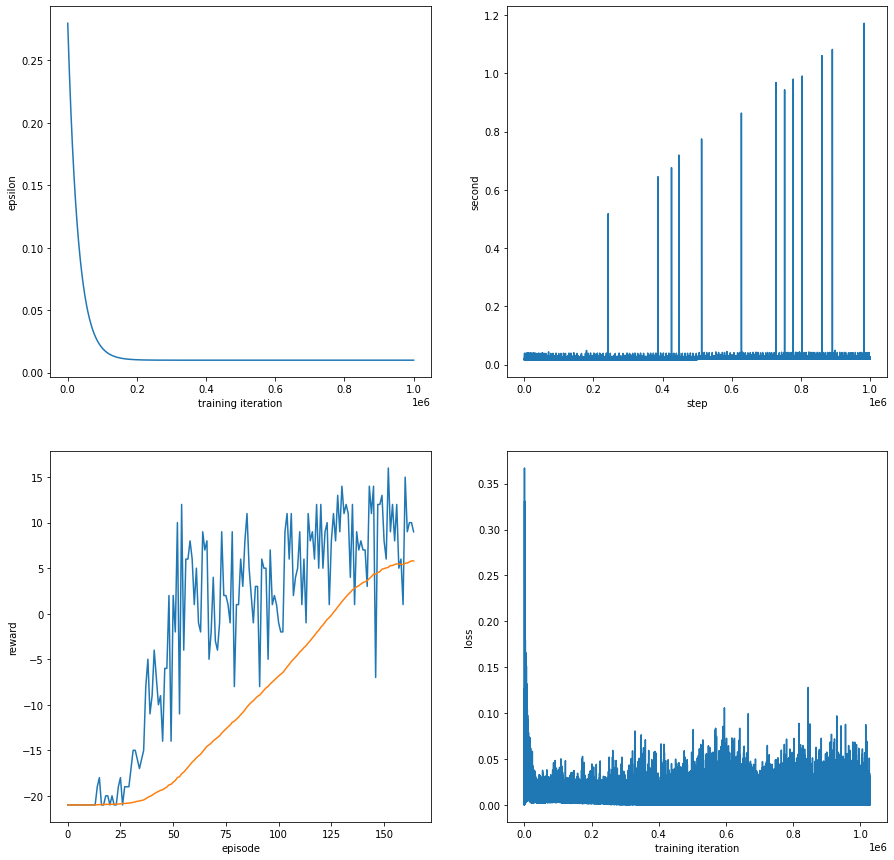

In [15]:
plot_data()

In [16]:
env.close()